Install package and load drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install git+https://github.com/PatBall1/detectree2.git@jb/july24

Mounted at /content/drive
  Cloning https://github.com/PatBall1/detectree2.git (to revision jb/july24) to /tmp/pip-req-build-olkwfht_
  Running command git clone --filter=blob:none --quiet https://github.com/PatBall1/detectree2.git /tmp/pip-req-build-olkwfht_
  Running command git checkout -b jb/july24 --track origin/jb/july24
  Switched to a new branch 'jb/july24'
  Branch 'jb/july24' set up to track remote branch 'jb/july24' from 'origin'.
  Resolved https://github.com/PatBall1/detectree2.git to commit 5682e7581cc651202dac77f81280b70ae82523a4
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-qw0uicnf/detectron2_c2cdb38123ee4d4e92b1912549331bea
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-qw0uicnf/detectron2_c2cdb38123ee4d4e92b1912549331bea
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5b72c27ae39f99db75d43f18fd

Registering the training (and validation) data. It is possible to register all the locations below.


Can duplicate to register many train/val folders (e.g. if you have multiple sites to train across)



In [ ]:
remove_registered_data("ParacouMS")


In [1]:
from detectree2.models.train import register_train_data, remove_registered_data
val_fold = 5
appends = "15_15_0.7"
site_path = "/content/drive/MyDrive/WORK/detectree2/data/Paracou"
train_location = site_path + "/tilesMS_" + appends + "/train/"
register_train_data(train_location, "ParacouMS", val_fold)

## Visualise training data

In [ ]:
import rasterio
from detectron2.utils.visualizer import Visualizer
from detectree2.models.train import combine_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display

#val_fold = 1
name = "Paracou"
tiles = "/tilesMS_" + appends + "/train"
train_location = site_path + tiles
dataset_dicts = combine_dicts(train_location, val_fold)
trees_metadata = MetadataCatalog.get(name + "_train")

# Function to normalize and convert multi-band image to RGB if needed
def prepare_image_for_visualization(image):
    if image.shape[2] == 3:
        # If the image has 3 bands, assume it's RGB
        image = np.stack([
            cv2.normalize(image[:, :, i], None, 0, 255, cv2.NORM_MINMAX)
            for i in range(3)
        ], axis=-1).astype(np.uint8)
    else:
        # If the image has more than 3 bands, choose the first 3 for visualization
        image = image[:, :, :3]  # Or select specific bands
        image = np.stack([
            cv2.normalize(image[:, :, i], None, 0, 255, cv2.NORM_MINMAX)
            for i in range(3)
        ], axis=-1).astype(np.uint8)

    return image

# Visualize each image in the dataset
for d in dataset_dicts:
    with rasterio.open(d["file_name"]) as src:
        img = src.read()  # Read all bands
        img = np.transpose(img, (1, 2, 0))  # Convert to HWC format
        img = prepare_image_for_visualization(img)  # Normalize and prepare for visualization

    #img = img[:, :, :3]/10
    v = Visualizer(img[:, :, ::-1]*20, metadata=trees_metadata, scale=0.5)
    out = v.draw_dataset_dict(d)
    image = out.get_image()[:, :, ::-1]
    display(Image.fromarray(image))



Output hidden; open in https://colab.research.google.com to view.

## Train!

GPU/CUDA should be available here. Chose which datasets you want to train and test on with `trains` and `tests`. Set up the configurations with `setup_cfg`.

If tuning has been completed, train and validation datasets can be combined in `trains` for full training.

Get training! Patience sets the number of evaluation periods that will be undergone without improvement in model performance before training will be terminated (best model will be saved).

To train the model sequentially on a series of sites, loop over the "names"

For that combines all sites, include them all in the `trains` and `tests` tuples

In [3]:
import rasterio
import os
import glob


# Read in geotif and assess mean and sd for each band
#site_path = "/content/drive/MyDrive/WORK/detectree2/data/Paracou"
folder_path = site_path + "/tilesMS_" + appends + "/"

# Select path of first .tif file
img_paths = glob.glob(folder_path + "*.tif")
img_path = img_paths[0]

# Open the raster file
with rasterio.open(img_path) as dataset:
    # Get the number of bands
    num_bands = dataset.count

# Print the number of bands
print(f'The raster has {num_bands} bands.')

The raster has 5 bands.


In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()

# Adjust PIXEL_MEAN and PIXEL_STD for the number of bands
default_pixel_mean = cfg.MODEL.PIXEL_MEAN
default_pixel_std = cfg.MODEL.PIXEL_STD

print("Default PIXEL_MEAN:", default_pixel_mean)
print("Default PIXEL_STD:", default_pixel_std)

# Extend or truncate the PIXEL_MEAN and PIXEL_STD based on num_bands
new_pixel_mean = (default_pixel_mean * (num_bands // len(default_pixel_mean)) +
                        default_pixel_mean[:num_bands % len(default_pixel_mean)])
new_pixel_std = (default_pixel_std * (num_bands // len(default_pixel_std)) +
                       default_pixel_std[:num_bands % len(default_pixel_std)])

print("New PIXEL_MEAN:", new_pixel_mean)
print("New PIXEL_STD:", new_pixel_std)

Default PIXEL_MEAN: [103.53, 116.28, 123.675]
Default PIXEL_STD: [1.0, 1.0, 1.0]
New PIXEL_MEAN: [103.53, 116.28, 123.675, 103.53, 116.28]
New PIXEL_STD: [1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
import torch.nn as nn
import torch

# Function to modify the first convolutional layer
def modify_conv1_weights(model, num_input_channels):
    with torch.no_grad():
        old_weights = model.backbone.bottom_up.stem.conv1.weight
        new_weights = torch.zeros((old_weights.size(0), num_input_channels, *old_weights.shape[2:]))

        # Example: Repeat the first 3 channels across the new channels
        for i in range(num_input_channels):
            new_weights[:, i, :, :] = old_weights[:, i % 3, :, :]

        model.backbone.bottom_up.stem.conv1 = nn.Conv2d(num_input_channels, old_weights.size(0), kernel_size=7, stride=2, padding=3, bias=False)
        model.backbone.bottom_up.stem.conv1.weight.copy_(new_weights)

In [4]:
from detectron2.modeling import build_model
#import torch
import torch.nn as nn
import torch.nn.init as init
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers
import numpy as np
from detectree2.models.train import MyTrainer, setup_cfg, modify_conv1_weights
from datetime import date


today = date.today()
today = today.strftime("%y%m%d")

names = ["ParacouMS",]
#num_bands = 5
#trained_model = "/content/drive/Shareddrives/detectree2/models/230103_resize_full/model_4.pth"

trains = (names[0] + "_train",)
tests = (names[0] + "_val",)
out_dir = "/content/drive/MyDrive/WORK/detectree2/models/" + today + "_ParacouMS"

base_model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"  # Path to the model config

# When you increase the number of channels (i.e., the number of filters) in a Convolutional Neural Network (CNN), the general recommendation is to decrease the learning rate
lrs = [0.003, 0.0003, 0.00003]


cfg = setup_cfg(base_model, trains, tests, workers = 2, eval_period=50,
                base_lr = lrs[1], backbone_freeze=0, gamma = 0.9,
                #update_model = trained_model,
                max_iter=500000, out_dir=out_dir, resize = "rand_fixed", imgmode="ms", num_bands=num_bands) # update_model arg can be used to load in trained  model


# Might be necessary to fix sizes?
cfg.INPUT.MIN_SIZE_TEST = 1000
#cfg.INPUT.MAX_SIZE_TEST = 2000

# Build the model
model = build_model(cfg)

# Adjust input layer to accept correct number of channels
modify_conv1_weights(model, num_input_channels=num_bands)

# Assuming num_classes is the number of classes (without background)
num_classes = 1  # Update this to your actual number of classes

# Update ROI heads and Mask predictor - THIS DOESNT SEEM TO BE WORKING WELL, OMIT?
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNOutputLayers(cfg, in_features)

in_channels = model.roi_heads.mask_head.predictor.in_channels
model.roi_heads.mask_head.predictor = nn.Conv2d(in_channels, cfg.MODEL.ROI_HEADS.NUM_CLASSES, kernel_size=1)

# Randomize the weights using one of the initialization methods
#init.kaiming_normal_(model.backbone.bottom_up.stem.conv1.weight, mode='fan_out', nonlinearity='relu')


In [ ]:
print(cfg.SOLVER.BASE_LR)
print(cfg.SOLVER.GAMMA)
print(cfg.SOLVER.MAX_ITER)
print(cfg.SOLVER.IMS_PER_BATCH)
print(cfg.SOLVER.STEPS)

0.0003
0.9
10000
2
(210000, 250000)


In [ ]:
from detectron2.data import DatasetCatalog

dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TRAIN[0])
print(f"Training dataset size: {len(dataset_dicts)}")
# If images are filtered due to missing annotations, check and adjust the filtering
dataset_dicts = [d for d in dataset_dicts if len(d.get("annotations", [])) > 0]
print(f"Filtered dataset size: {len(dataset_dicts)}")


Training dataset size: 76
Filtered dataset size: 76


In [5]:
cfg.SOLVER.IMS_PER_BATCH = 2 # Might need to reduce to 1 to go easy on GPU allocation

In [6]:
trainer =  MyTrainer(cfg, patience=5)
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)
trainer.train()

[09/03 15:59:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 204MB/s]                           
backbone.bottom_up.stem.conv1.weight
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/03 16:01:49 d2.utils.events]:  eta: 7 days, 20:30:31  iter: 19  total_loss: 4.638  loss_cls: 1.012  loss_box_reg: 0.09653  loss_mask: 0.7481  loss_rpn_cls: 2.128  loss_rpn_loc: 0.6183    time: 1.3135  last_time: 1.1480  data_time: 0.0606  last_data_time: 0.0340   lr: 4.7752e-05  max_mem: 7829M
[09/03 16:02:19 d2.utils.events]:  eta: 7 days, 18:28:28  iter: 39  total_loss: 2.716  loss_cls: 0.7306  loss_box_reg: 0.7608  loss_mask: 0.7104  loss_rpn_cls: 0.3061  loss_rpn_loc: 0.2234    time: 1.2989  last_time: 1.6753  data_time: 0.0230  last_data_time: 0.0399   lr: 9.7702e-05  max_mem: 7829M
[09/03 16:02:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:02:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:02:32 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:02:32 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:0

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:02:39 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1826 s/iter. Eval: 0.2011 s/iter. Total: 0.3884 s/iter. ETA=0:00:10
[09/03 16:02:44 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0053 s/iter. Inference: 0.1814 s/iter. Eval: 0.2021 s/iter. Total: 0.3889 s/iter. ETA=0:00:05
[09/03 16:02:49 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0066 s/iter. Inference: 0.1825 s/iter. Eval: 0.2359 s/iter. Total: 0.4252 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:02:50 d2.evaluation.evaluator]: Total inference time: 0:00:13.901738 (0.434429 s / iter per device, on 1 devices)
[09/03 16:02:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182489 s / iter per device, on 1 devices)
[09/03 16:02:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:02:50 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:02:50 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:02:50 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:02:51 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[09/03 16:02:51 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:02:51 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:03:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:03:01 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:03:01 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:03:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:03:01 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:03:07 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0264 s/iter. Inference: 0.1958 s/iter. Eval: 0.3059 s/iter. Total: 0.5281 s/iter. ETA=0:00:13
[09/03 16:03:12 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0154 s/iter. Inference: 0.1881 s/iter. Eval: 0.2491 s/iter. Total: 0.4530 s/iter. ETA=0:00:05
[09/03 16:03:17 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0116 s/iter. Inference: 0.1854 s/iter. Eval: 0.2280 s/iter. Total: 0.4254 s/iter. ETA=0:00:00
[09/03 16:03:17 d2.evaluation.evaluator]: Total inference time: 0:00:13.669259 (0.427164 s / iter per device, on 1 devices)
[09/03 16:03:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185376 s / iter per device, on 1 devices)
[09/03 16:03:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:03:17 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:03:17 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:04:32 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0048 s/iter. Inference: 0.1807 s/iter. Eval: 0.1980 s/iter. Total: 0.3834 s/iter. ETA=0:00:09
[09/03 16:04:37 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0082 s/iter. Inference: 0.1846 s/iter. Eval: 0.2366 s/iter. Total: 0.4295 s/iter. ETA=0:00:06
[09/03 16:04:42 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0091 s/iter. Inference: 0.1844 s/iter. Eval: 0.2418 s/iter. Total: 0.4356 s/iter. ETA=0:00:01
[09/03 16:04:43 d2.evaluation.evaluator]: Total inference time: 0:00:13.872956 (0.433530 s / iter per device, on 1 devices)
[09/03 16:04:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184010 s / iter per device, on 1 devices)
[09/03 16:04:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:04:43 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:04:43 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:04:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:04:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:04:54 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:04:54 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:04:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:04:54 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:04:59 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1808 s/iter. Eval: 0.1944 s/iter. Total: 0.3798 s/iter. ETA=0:00:09
[09/03 16:05:04 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0056 s/iter. Inference: 0.1819 s/iter. Eval: 0.1957 s/iter. Total: 0.3834 s/iter. ETA=0:00:04
[09/03 16:05:09 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0068 s/iter. Inference: 0.1849 s/iter. Eval: 0.2296 s/iter. Total: 0.4215 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:05:10 d2.evaluation.evaluator]: Total inference time: 0:00:13.766847 (0.430214 s / iter per device, on 1 devices)
[09/03 16:05:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184752 s / iter per device, on 1 devices)
[09/03 16:05:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:05:10 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:05:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:05:10 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:05:10 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[09/03 16:05:10 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:05:10 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:06:27 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0127 s/iter. Inference: 0.1920 s/iter. Eval: 0.3064 s/iter. Total: 0.5111 s/iter. ETA=0:00:13
[09/03 16:06:32 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0083 s/iter. Inference: 0.1836 s/iter. Eval: 0.2416 s/iter. Total: 0.4338 s/iter. ETA=0:00:05
[09/03 16:06:37 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0072 s/iter. Inference: 0.1816 s/iter. Eval: 0.2252 s/iter. Total: 0.4144 s/iter. ETA=0:00:00
[09/03 16:06:38 d2.evaluation.evaluator]: Total inference time: 0:00:13.329160 (0.416536 s / iter per device, on 1 devices)
[09/03 16:06:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181650 s / iter per device, on 1 devices)
[09/03 16:06:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:06:38 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:06:38 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:06:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:06:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:06:50 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:06:50 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:06:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:06:50 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:06:54 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1809 s/iter. Eval: 0.1984 s/iter. Total: 0.3839 s/iter. ETA=0:00:09
[09/03 16:06:59 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0101 s/iter. Inference: 0.1829 s/iter. Eval: 0.2390 s/iter. Total: 0.4322 s/iter. ETA=0:00:06
[09/03 16:07:05 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0099 s/iter. Inference: 0.1857 s/iter. Eval: 0.2396 s/iter. Total: 0.4354 s/iter. ETA=0:00:01
[09/03 16:07:06 d2.evaluation.evaluator]: Total inference time: 0:00:13.835144 (0.432348 s / iter per device, on 1 devices)
[09/03 16:07:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184926 s / iter per device, on 1 devices)
[09/03 16:07:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:07:06 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:07:06 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:08:23 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0049 s/iter. Inference: 0.1811 s/iter. Eval: 0.1992 s/iter. Total: 0.3851 s/iter. ETA=0:00:10
[09/03 16:08:28 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0054 s/iter. Inference: 0.1811 s/iter. Eval: 0.1970 s/iter. Total: 0.3837 s/iter. ETA=0:00:04
[09/03 16:08:33 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0095 s/iter. Inference: 0.1834 s/iter. Eval: 0.2304 s/iter. Total: 0.4235 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:08:34 d2.evaluation.evaluator]: Total inference time: 0:00:13.847327 (0.432729 s / iter per device, on 1 devices)
[09/03 16:08:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183280 s / iter per device, on 1 devices)
[09/03 16:08:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:08:34 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:08:34 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:08:34 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:08:34 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:08:34 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:08:34 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:08:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:08:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:08:44 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:08:44 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:08:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:08:44 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:08:50 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0110 s/iter. Inference: 0.1883 s/iter. Eval: 0.3075 s/iter. Total: 0.5069 s/iter. ETA=0:00:13
[09/03 16:08:55 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0086 s/iter. Inference: 0.1857 s/iter. Eval: 0.2437 s/iter. Total: 0.4384 s/iter. ETA=0:00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:09:00 d2.evaluation.evaluator]: Total inference time: 0:00:13.359382 (0.417481 s / iter per device, on 1 devices)
[09/03 16:09:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183428 s / iter per device, on 1 devices)
[09/03 16:09:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:09:00 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:09:00 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:09:00 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:09:00 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:09:00 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:09:00 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:10:19 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0120 s/iter. Inference: 0.1850 s/iter. Eval: 0.2555 s/iter. Total: 0.4525 s/iter. ETA=0:00:11
[09/03 16:10:24 d2.evaluation.evaluator]: Inference done 21/37. Dataloading: 0.0179 s/iter. Inference: 0.1903 s/iter. Eval: 0.2751 s/iter. Total: 0.4836 s/iter. ETA=0:00:07
[09/03 16:10:29 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0126 s/iter. Inference: 0.1855 s/iter. Eval: 0.2420 s/iter. Total: 0.4403 s/iter. ETA=0:00:01
[09/03 16:10:30 d2.evaluation.evaluator]: Total inference time: 0:00:13.976130 (0.436754 s / iter per device, on 1 devices)
[09/03 16:10:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184708 s / iter per device, on 1 devices)
[09/03 16:10:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:10:30 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:10:30 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:10:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:10:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:10:43 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:10:43 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:10:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:10:43 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:10:47 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1836 s/iter. Eval: 0.1949 s/iter. Total: 0.3832 s/iter. ETA=0:00:09
[09/03 16:10:53 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0065 s/iter. Inference: 0.1835 s/iter. Eval: 0.2246 s/iter. Total: 0.4148 s/iter. ETA=0:00:05
[09/03 16:10:58 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0104 s/iter. Inference: 0.1863 s/iter. Eval: 0.2433 s/iter. Total: 0.4403 s/iter. ETA=0:00:01
[09/03 16:10:59 d2.evaluation.evaluator]: Total inference time: 0:00:14.028514 (0.438391 s / iter per device, on 1 devices)
[09/03 16:10:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185666 s / iter per device, on 1 devices)
[09/03 16:10:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:10:59 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:10:59 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:12:16 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0070 s/iter. Inference: 0.1887 s/iter. Eval: 0.2991 s/iter. Total: 0.4948 s/iter. ETA=0:00:12
[09/03 16:12:21 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0061 s/iter. Inference: 0.1837 s/iter. Eval: 0.2305 s/iter. Total: 0.4205 s/iter. ETA=0:00:05
[09/03 16:12:26 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0061 s/iter. Inference: 0.1831 s/iter. Eval: 0.2299 s/iter. Total: 0.4194 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:12:26 d2.evaluation.evaluator]: Total inference time: 0:00:13.596311 (0.424885 s / iter per device, on 1 devices)
[09/03 16:12:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183070 s / iter per device, on 1 devices)
[09/03 16:12:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:12:26 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:12:26 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:12:26 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:12:26 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:12:26 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:12:26 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:12:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:12:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:12:37 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:12:37 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:12:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:12:37 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:12:43 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0091 s/iter. Inference: 0.1921 s/iter. Eval: 0.3017 s/iter. Total: 0.5029 s/iter. ETA=0:00:13
[09/03 16:12:48 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0078 s/iter. Inference: 0.1892 s/iter. Eval: 0.2542 s/iter. Total: 0.4515 s/iter. ETA=0:00:06
[09/03 16:12:53 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0069 s/iter. Inference: 0.1857 s/iter. Eval: 0.2313 s/iter. Total: 0.4241 s/iter. ETA=0:00:00
[09/03 16:12:53 d2.evaluation.evaluator]: Total inference time: 0:00:13.594534 (0.424829 s / iter per device, on 1 devices)
[09/03 16:12:53 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185520 s / iter per device, on 1 devices)
[09/03 16:12:53 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:12:53 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:12:53 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:14:07 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1827 s/iter. Eval: 0.2015 s/iter. Total: 0.3889 s/iter. ETA=0:00:10
[09/03 16:14:12 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0101 s/iter. Inference: 0.1860 s/iter. Eval: 0.2353 s/iter. Total: 0.4317 s/iter. ETA=0:00:06
[09/03 16:14:18 d2.evaluation.evaluator]: Inference done 32/37. Dataloading: 0.0131 s/iter. Inference: 0.1873 s/iter. Eval: 0.2667 s/iter. Total: 0.4674 s/iter. ETA=0:00:02
[09/03 16:14:21 d2.evaluation.evaluator]: Total inference time: 0:00:15.548559 (0.485892 s / iter per device, on 1 devices)
[09/03 16:14:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.186461 s / iter per device, on 1 devices)
[09/03 16:14:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:14:21 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:14:21 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:14:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:14:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:14:32 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:14:32 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:14:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:14:32 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:14:36 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0048 s/iter. Inference: 0.1824 s/iter. Eval: 0.2003 s/iter. Total: 0.3875 s/iter. ETA=0:00:10
[09/03 16:14:41 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0057 s/iter. Inference: 0.2043 s/iter. Eval: 0.2013 s/iter. Total: 0.4116 s/iter. ETA=0:00:05
[09/03 16:14:47 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0072 s/iter. Inference: 0.1987 s/iter. Eval: 0.2368 s/iter. Total: 0.4429 s/iter. ETA=0:00:01
[09/03 16:14:48 d2.evaluation.evaluator]: Total inference time: 0:00:14.265407 (0.445794 s / iter per device, on 1 devices)
[09/03 16:14:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.197314 s / iter per device, on 1 devices)
[09/03 16:14:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:14:48 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:14:48 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:16:06 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0050 s/iter. Inference: 0.1860 s/iter. Eval: 0.2187 s/iter. Total: 0.4097 s/iter. ETA=0:00:10
[09/03 16:16:11 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0060 s/iter. Inference: 0.1813 s/iter. Eval: 0.2054 s/iter. Total: 0.3928 s/iter. ETA=0:00:05
[09/03 16:16:16 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0061 s/iter. Inference: 0.1813 s/iter. Eval: 0.2146 s/iter. Total: 0.4021 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:16:17 d2.evaluation.evaluator]: Total inference time: 0:00:13.044266 (0.407633 s / iter per device, on 1 devices)
[09/03 16:16:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181450 s / iter per device, on 1 devices)
[09/03 16:16:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:16:17 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:16:17 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:16:17 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:16:17 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:16:17 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:16:17 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:16:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:16:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:16:29 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:16:29 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:16:29 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:16:29 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:16:34 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0110 s/iter. Inference: 0.1917 s/iter. Eval: 0.3098 s/iter. Total: 0.5126 s/iter. ETA=0:00:13
[09/03 16:16:39 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0090 s/iter. Inference: 0.1889 s/iter. Eval: 0.2538 s/iter. Total: 0.4521 s/iter. ETA=0:00:06
[09/03 16:16:45 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0074 s/iter. Inference: 0.1858 s/iter. Eval: 0.2288 s/iter. Total: 0.4223 s/iter. ETA=0:00:00
[09/03 16:16:45 d2.evaluation.evaluator]: Total inference time: 0:00:13.578339 (0.424323 s / iter per device, on 1 devices)
[09/03 16:16:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185769 s / iter per device, on 1 devices)
[09/03 16:16:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:16:45 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:16:45 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:18:00 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0051 s/iter. Inference: 0.1802 s/iter. Eval: 0.1991 s/iter. Total: 0.3844 s/iter. ETA=0:00:09
[09/03 16:18:05 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0067 s/iter. Inference: 0.1816 s/iter. Eval: 0.2224 s/iter. Total: 0.4109 s/iter. ETA=0:00:05
[09/03 16:18:10 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0079 s/iter. Inference: 0.1845 s/iter. Eval: 0.2420 s/iter. Total: 0.4347 s/iter. ETA=0:00:01
[09/03 16:18:11 d2.evaluation.evaluator]: Total inference time: 0:00:13.827022 (0.432094 s / iter per device, on 1 devices)
[09/03 16:18:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183848 s / iter per device, on 1 devices)
[09/03 16:18:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:18:11 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:18:11 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:18:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:18:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:18:23 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:18:23 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:18:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:18:23 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:18:28 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0049 s/iter. Inference: 0.1826 s/iter. Eval: 0.1983 s/iter. Total: 0.3859 s/iter. ETA=0:00:10
[09/03 16:18:33 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0056 s/iter. Inference: 0.1818 s/iter. Eval: 0.1984 s/iter. Total: 0.3860 s/iter. ETA=0:00:05
[09/03 16:18:38 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0071 s/iter. Inference: 0.1828 s/iter. Eval: 0.2407 s/iter. Total: 0.4308 s/iter. ETA=0:00:01
[09/03 16:18:39 d2.evaluation.evaluator]: Total inference time: 0:00:14.103355 (0.440730 s / iter per device, on 1 devices)
[09/03 16:18:39 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182893 s / iter per device, on 1 devices)
[09/03 16:18:39 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:18:39 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:18:40 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:19:57 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0126 s/iter. Inference: 0.1923 s/iter. Eval: 0.2468 s/iter. Total: 0.4518 s/iter. ETA=0:00:11
[09/03 16:20:03 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0080 s/iter. Inference: 0.1833 s/iter. Eval: 0.2091 s/iter. Total: 0.4006 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:20:07 d2.evaluation.evaluator]: Total inference time: 0:00:12.726050 (0.397689 s / iter per device, on 1 devices)
[09/03 16:20:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181234 s / iter per device, on 1 devices)
[09/03 16:20:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:20:07 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:20:07 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:20:07 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:20:07 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:20:08 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:20:08 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:20:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:20:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:20:19 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:20:19 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:20:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:20:19 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:20:24 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0076 s/iter. Inference: 0.1910 s/iter. Eval: 0.2512 s/iter. Total: 0.4497 s/iter. ETA=0:00:11
[09/03 16:20:30 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0104 s/iter. Inference: 0.1893 s/iter. Eval: 0.2762 s/iter. Total: 0.4763 s/iter. ETA=0:00:07
[09/03 16:20:35 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0083 s/iter. Inference: 0.1847 s/iter. Eval: 0.2369 s/iter. Total: 0.4302 s/iter. ETA=0:00:00
[09/03 16:20:35 d2.evaluation.evaluator]: Total inference time: 0:00:13.789632 (0.430926 s / iter per device, on 1 devices)
[09/03 16:20:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184637 s / iter per device, on 1 devices)
[09/03 16:20:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:20:35 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:20:35 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:21:49 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0052 s/iter. Inference: 0.1810 s/iter. Eval: 0.1967 s/iter. Total: 0.3829 s/iter. ETA=0:00:09
[09/03 16:21:54 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0058 s/iter. Inference: 0.1815 s/iter. Eval: 0.2022 s/iter. Total: 0.3897 s/iter. ETA=0:00:05
[09/03 16:21:59 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0122 s/iter. Inference: 0.1858 s/iter. Eval: 0.2392 s/iter. Total: 0.4376 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:22:01 d2.evaluation.evaluator]: Total inference time: 0:00:13.905620 (0.434551 s / iter per device, on 1 devices)
[09/03 16:22:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185227 s / iter per device, on 1 devices)
[09/03 16:22:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:22:01 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:22:01 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:22:01 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:22:01 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:22:01 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:22:01 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:22:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:22:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:22:11 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:22:11 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:22:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:22:11 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:22:17 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0131 s/iter. Inference: 0.1924 s/iter. Eval: 0.2511 s/iter. Total: 0.4566 s/iter. ETA=0:00:11
[09/03 16:22:22 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0089 s/iter. Inference: 0.1872 s/iter. Eval: 0.2644 s/iter. Total: 0.4607 s/iter. ETA=0:00:06
[09/03 16:22:27 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0079 s/iter. Inference: 0.1851 s/iter. Eval: 0.2455 s/iter. Total: 0.4387 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:22:28 d2.evaluation.evaluator]: Total inference time: 0:00:14.269732 (0.445929 s / iter per device, on 1 devices)
[09/03 16:22:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184898 s / iter per device, on 1 devices)
[09/03 16:22:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:22:28 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:22:29 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:22:29 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:22:29 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:22:29 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:22:29 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:23:52 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0064 s/iter. Inference: 0.1832 s/iter. Eval: 0.1980 s/iter. Total: 0.3877 s/iter. ETA=0:00:10
[09/03 16:23:58 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0077 s/iter. Inference: 0.1825 s/iter. Eval: 0.2085 s/iter. Total: 0.3988 s/iter. ETA=0:00:05
[09/03 16:24:03 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0093 s/iter. Inference: 0.1850 s/iter. Eval: 0.2398 s/iter. Total: 0.4343 s/iter. ETA=0:00:00
[09/03 16:24:04 d2.evaluation.evaluator]: Total inference time: 0:00:13.998163 (0.437443 s / iter per device, on 1 devices)
[09/03 16:24:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184918 s / iter per device, on 1 devices)
[09/03 16:24:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:24:04 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:24:04 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:24:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:24:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:24:14 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:24:14 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:24:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:24:14 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:24:20 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0181 s/iter. Inference: 0.1938 s/iter. Eval: 0.2990 s/iter. Total: 0.5109 s/iter. ETA=0:00:13
[09/03 16:24:25 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0123 s/iter. Inference: 0.1898 s/iter. Eval: 0.2626 s/iter. Total: 0.4653 s/iter. ETA=0:00:06
[09/03 16:24:30 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0095 s/iter. Inference: 0.1860 s/iter. Eval: 0.2357 s/iter. Total: 0.4316 s/iter. ETA=0:00:00
[09/03 16:24:31 d2.evaluation.evaluator]: Total inference time: 0:00:13.937875 (0.435559 s / iter per device, on 1 devices)
[09/03 16:24:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185810 s / iter per device, on 1 devices)
[09/03 16:24:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:24:31 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:24:31 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:25:44 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0049 s/iter. Inference: 0.1818 s/iter. Eval: 0.1938 s/iter. Total: 0.3805 s/iter. ETA=0:00:09
[09/03 16:25:49 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0081 s/iter. Inference: 0.1835 s/iter. Eval: 0.2319 s/iter. Total: 0.4238 s/iter. ETA=0:00:05
[09/03 16:25:55 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0097 s/iter. Inference: 0.1851 s/iter. Eval: 0.2376 s/iter. Total: 0.4327 s/iter. ETA=0:00:00
[09/03 16:25:55 d2.evaluation.evaluator]: Total inference time: 0:00:13.809126 (0.431535 s / iter per device, on 1 devices)
[09/03 16:25:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184789 s / iter per device, on 1 devices)
[09/03 16:25:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:25:55 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:25:55 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:26:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:26:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:26:06 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:26:06 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:26:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:26:06 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:26:11 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0061 s/iter. Inference: 0.1831 s/iter. Eval: 0.1961 s/iter. Total: 0.3854 s/iter. ETA=0:00:10
[09/03 16:26:16 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0061 s/iter. Inference: 0.1818 s/iter. Eval: 0.2145 s/iter. Total: 0.4026 s/iter. ETA=0:00:05
[09/03 16:26:22 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0074 s/iter. Inference: 0.1837 s/iter. Eval: 0.2366 s/iter. Total: 0.4280 s/iter. ETA=0:00:00
[09/03 16:26:23 d2.evaluation.evaluator]: Total inference time: 0:00:13.932026 (0.435376 s / iter per device, on 1 devices)
[09/03 16:26:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183650 s / iter per device, on 1 devices)
[09/03 16:26:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:26:23 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:26:23 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:27:41 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0051 s/iter. Inference: 0.1823 s/iter. Eval: 0.2324 s/iter. Total: 0.4199 s/iter. ETA=0:00:10
[09/03 16:27:47 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0055 s/iter. Inference: 0.1810 s/iter. Eval: 0.2060 s/iter. Total: 0.3927 s/iter. ETA=0:00:04
[09/03 16:27:52 d2.evaluation.evaluator]: Total inference time: 0:00:12.970294 (0.405322 s / iter per device, on 1 devices)
[09/03 16:27:52 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181049 s / iter per device, on 1 devices)
[09/03 16:27:52 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:27:52 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:27:52 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:27:52 d2.evaluation.fast_

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:28:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:28:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:28:03 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:28:03 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:28:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:28:03 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:28:08 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0136 s/iter. Inference: 0.1868 s/iter. Eval: 0.2583 s/iter. Total: 0.4587 s/iter. ETA=0:00:11
[09/03 16:28:14 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0102 s/iter. Inference: 0.1896 s/iter. Eval: 0.2652 s/iter. Total: 0.4653 s/iter. ETA=0:00:06
[09/03 16:28:19 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0083 s/iter. Inference: 0.1857 s/iter. Eval: 0.2374 s/iter. Total: 0.4316 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:28:19 d2.evaluation.evaluator]: Total inference time: 0:00:13.780877 (0.430652 s / iter per device, on 1 devices)
[09/03 16:28:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185273 s / iter per device, on 1 devices)
[09/03 16:28:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:28:19 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:28:19 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:28:19 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:28:20 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:28:20 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:28:20 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:29:33 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0044 s/iter. Inference: 0.1805 s/iter. Eval: 0.1931 s/iter. Total: 0.3780 s/iter. ETA=0:00:09
[09/03 16:29:38 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0069 s/iter. Inference: 0.1821 s/iter. Eval: 0.2055 s/iter. Total: 0.3946 s/iter. ETA=0:00:05
[09/03 16:29:43 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0120 s/iter. Inference: 0.1859 s/iter. Eval: 0.2402 s/iter. Total: 0.4385 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:29:45 d2.evaluation.evaluator]: Total inference time: 0:00:14.050840 (0.439089 s / iter per device, on 1 devices)
[09/03 16:29:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185370 s / iter per device, on 1 devices)
[09/03 16:29:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:29:45 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:29:45 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:29:45 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:29:45 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:29:45 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:29:45 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:29:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:29:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:29:55 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:29:55 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:29:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:29:55 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:30:01 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0141 s/iter. Inference: 0.2003 s/iter. Eval: 0.3107 s/iter. Total: 0.5252 s/iter. ETA=0:00:13
[09/03 16:30:06 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0095 s/iter. Inference: 0.1882 s/iter. Eval: 0.2345 s/iter. Total: 0.4328 s/iter. ETA=0:00:05
[09/03 16:30:11 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0081 s/iter. Inference: 0.1857 s/iter. Eval: 0.2333 s/iter. Total: 0.4275 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:30:12 d2.evaluation.evaluator]: Total inference time: 0:00:13.853459 (0.432921 s / iter per device, on 1 devices)
[09/03 16:30:12 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185701 s / iter per device, on 1 devices)
[09/03 16:30:12 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:30:12 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:30:12 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:30:12 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:30:12 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 16:30:12 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:30:12 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:31:31 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0133 s/iter. Inference: 0.1907 s/iter. Eval: 0.2945 s/iter. Total: 0.4984 s/iter. ETA=0:00:12
[09/03 16:31:36 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0092 s/iter. Inference: 0.1852 s/iter. Eval: 0.2539 s/iter. Total: 0.4489 s/iter. ETA=0:00:06
[09/03 16:31:42 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0076 s/iter. Inference: 0.1827 s/iter. Eval: 0.2297 s/iter. Total: 0.4203 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:31:42 d2.evaluation.evaluator]: Total inference time: 0:00:13.521850 (0.422558 s / iter per device, on 1 devices)
[09/03 16:31:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182679 s / iter per device, on 1 devices)
[09/03 16:31:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:31:42 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:31:42 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:31:42 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:31:42 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:31:42 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:31:42 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:31:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:31:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:31:54 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:31:54 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:31:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:31:54 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:31:58 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0045 s/iter. Inference: 0.1817 s/iter. Eval: 0.1978 s/iter. Total: 0.3840 s/iter. ETA=0:00:09
[09/03 16:32:03 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0064 s/iter. Inference: 0.1846 s/iter. Eval: 0.2209 s/iter. Total: 0.4120 s/iter. ETA=0:00:05
[09/03 16:32:09 d2.evaluation.evaluator]: Inference done 33/37. Dataloading: 0.0140 s/iter. Inference: 0.1878 s/iter. Eval: 0.2485 s/iter. Total: 0.4504 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:32:10 d2.evaluation.evaluator]: Total inference time: 0:00:14.217715 (0.444304 s / iter per device, on 1 devices)
[09/03 16:32:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.186784 s / iter per device, on 1 devices)
[09/03 16:32:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:32:10 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:32:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:32:10 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:32:10 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:32:10 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:32:10 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:33:27 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0045 s/iter. Inference: 0.1797 s/iter. Eval: 0.1986 s/iter. Total: 0.3829 s/iter. ETA=0:00:09
[09/03 16:33:32 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0054 s/iter. Inference: 0.1792 s/iter. Eval: 0.1964 s/iter. Total: 0.3812 s/iter. ETA=0:00:04
[09/03 16:33:37 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0076 s/iter. Inference: 0.1801 s/iter. Eval: 0.2235 s/iter. Total: 0.4113 s/iter. ETA=0:00:00
[09/03 16:33:38 d2.evaluation.evaluator]: Total inference time: 0:00:13.352071 (0.417252 s / iter per device, on 1 devices)
[09/03 16:33:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180059 s / iter per device, on 1 devices)
[09/03 16:33:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:33:38 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:33:38 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:33:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:33:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:33:48 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:33:48 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:33:48 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:33:48 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:33:54 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0169 s/iter. Inference: 0.1976 s/iter. Eval: 0.3063 s/iter. Total: 0.5208 s/iter. ETA=0:00:13
[09/03 16:33:59 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0114 s/iter. Inference: 0.1880 s/iter. Eval: 0.2436 s/iter. Total: 0.4433 s/iter. ETA=0:00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:34:04 d2.evaluation.evaluator]: Total inference time: 0:00:13.424793 (0.419525 s / iter per device, on 1 devices)
[09/03 16:34:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184472 s / iter per device, on 1 devices)
[09/03 16:34:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:34:04 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:34:04 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:34:04 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:34:04 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:34:04 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:34:04 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:35:24 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0098 s/iter. Inference: 0.1863 s/iter. Eval: 0.2751 s/iter. Total: 0.4712 s/iter. ETA=0:00:12
[09/03 16:35:29 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0103 s/iter. Inference: 0.1846 s/iter. Eval: 0.2526 s/iter. Total: 0.4480 s/iter. ETA=0:00:06
[09/03 16:35:34 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0081 s/iter. Inference: 0.1804 s/iter. Eval: 0.2208 s/iter. Total: 0.4097 s/iter. ETA=0:00:00
[09/03 16:35:35 d2.evaluation.evaluator]: Total inference time: 0:00:13.174132 (0.411692 s / iter per device, on 1 devices)
[09/03 16:35:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180399 s / iter per device, on 1 devices)
[09/03 16:35:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:35:35 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:35:35 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:35:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:35:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:35:46 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:35:46 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:35:46 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:35:46 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:35:50 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1786 s/iter. Eval: 0.1891 s/iter. Total: 0.3724 s/iter. ETA=0:00:09
[09/03 16:35:56 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0064 s/iter. Inference: 0.1797 s/iter. Eval: 0.2059 s/iter. Total: 0.3923 s/iter. ETA=0:00:05
[09/03 16:36:01 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0102 s/iter. Inference: 0.1818 s/iter. Eval: 0.2253 s/iter. Total: 0.4175 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:36:02 d2.evaluation.evaluator]: Total inference time: 0:00:13.334239 (0.416695 s / iter per device, on 1 devices)
[09/03 16:36:02 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181403 s / iter per device, on 1 devices)
[09/03 16:36:02 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:36:02 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:36:02 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:36:02 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:36:02 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:36:02 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:36:02 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:37:18 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0052 s/iter. Inference: 0.1877 s/iter. Eval: 0.2128 s/iter. Total: 0.4058 s/iter. ETA=0:00:10
[09/03 16:37:23 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0056 s/iter. Inference: 0.1794 s/iter. Eval: 0.1934 s/iter. Total: 0.3787 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:37:27 d2.evaluation.evaluator]: Total inference time: 0:00:12.166402 (0.380200 s / iter per device, on 1 devices)
[09/03 16:37:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.178191 s / iter per device, on 1 devices)
[09/03 16:37:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:37:27 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:37:27 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:37:27 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:37:27 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 16:37:27 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:37:27 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:37:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:37:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:37:39 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:37:39 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:37:39 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:37:39 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:37:43 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0097 s/iter. Inference: 0.1781 s/iter. Eval: 0.2067 s/iter. Total: 0.3944 s/iter. ETA=0:00:10
[09/03 16:37:49 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0126 s/iter. Inference: 0.1873 s/iter. Eval: 0.2575 s/iter. Total: 0.4576 s/iter. ETA=0:00:06
[09/03 16:37:54 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0102 s/iter. Inference: 0.1823 s/iter. Eval: 0.2320 s/iter. Total: 0.4248 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:37:55 d2.evaluation.evaluator]: Total inference time: 0:00:13.625650 (0.425802 s / iter per device, on 1 devices)
[09/03 16:37:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182188 s / iter per device, on 1 devices)
[09/03 16:37:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:37:55 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:37:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:37:55 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:37:55 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:37:55 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:37:55 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:39:08 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0050 s/iter. Inference: 0.1772 s/iter. Eval: 0.1786 s/iter. Total: 0.3608 s/iter. ETA=0:00:09
[09/03 16:39:13 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0057 s/iter. Inference: 0.1778 s/iter. Eval: 0.1819 s/iter. Total: 0.3656 s/iter. ETA=0:00:04
[09/03 16:39:19 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0064 s/iter. Inference: 0.1782 s/iter. Eval: 0.2149 s/iter. Total: 0.3997 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:39:19 d2.evaluation.evaluator]: Total inference time: 0:00:12.938499 (0.404328 s / iter per device, on 1 devices)
[09/03 16:39:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.178231 s / iter per device, on 1 devices)
[09/03 16:39:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:39:19 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:39:19 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:39:19 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:39:19 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:39:19 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:39:19 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:39:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:39:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:39:29 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:39:29 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:39:29 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:39:29 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:39:35 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0136 s/iter. Inference: 0.1908 s/iter. Eval: 0.2827 s/iter. Total: 0.4871 s/iter. ETA=0:00:12
[09/03 16:39:40 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0089 s/iter. Inference: 0.1826 s/iter. Eval: 0.2266 s/iter. Total: 0.4184 s/iter. ETA=0:00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:39:45 d2.evaluation.evaluator]: Total inference time: 0:00:12.704047 (0.397001 s / iter per device, on 1 devices)
[09/03 16:39:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180194 s / iter per device, on 1 devices)
[09/03 16:39:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:39:45 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:39:45 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:39:45 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:39:45 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:39:45 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:39:45 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:41:00 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1757 s/iter. Eval: 0.1765 s/iter. Total: 0.3568 s/iter. ETA=0:00:09
[09/03 16:41:05 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0105 s/iter. Inference: 0.1793 s/iter. Eval: 0.2058 s/iter. Total: 0.3957 s/iter. ETA=0:00:05
[09/03 16:41:11 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0107 s/iter. Inference: 0.1801 s/iter. Eval: 0.2117 s/iter. Total: 0.4028 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:41:11 d2.evaluation.evaluator]: Total inference time: 0:00:12.970796 (0.405337 s / iter per device, on 1 devices)
[09/03 16:41:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180107 s / iter per device, on 1 devices)
[09/03 16:41:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:41:11 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:41:11 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:41:11 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:41:11 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:41:11 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:41:11 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:41:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:41:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:41:21 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:41:21 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:41:21 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:41:21 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:41:26 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1785 s/iter. Eval: 0.1724 s/iter. Total: 0.3557 s/iter. ETA=0:00:09
[09/03 16:41:31 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0058 s/iter. Inference: 0.1777 s/iter. Eval: 0.1764 s/iter. Total: 0.3601 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:41:36 d2.evaluation.evaluator]: Total inference time: 0:00:11.921801 (0.372556 s / iter per device, on 1 devices)
[09/03 16:41:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.177285 s / iter per device, on 1 devices)
[09/03 16:41:36 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:41:36 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:41:36 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:41:36 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:41:36 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 16:41:36 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:41:36 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:42:51 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0125 s/iter. Inference: 0.1794 s/iter. Eval: 0.2396 s/iter. Total: 0.4315 s/iter. ETA=0:00:11
[09/03 16:42:56 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0152 s/iter. Inference: 0.1829 s/iter. Eval: 0.2512 s/iter. Total: 0.4495 s/iter. ETA=0:00:06
[09/03 16:43:01 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0107 s/iter. Inference: 0.1779 s/iter. Eval: 0.2093 s/iter. Total: 0.3981 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:43:01 d2.evaluation.evaluator]: Total inference time: 0:00:12.815151 (0.400473 s / iter per device, on 1 devices)
[09/03 16:43:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.177889 s / iter per device, on 1 devices)
[09/03 16:43:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:43:01 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:43:01 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:43:01 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:43:01 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:43:01 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:43:01 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:43:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:43:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:43:12 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:43:12 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:43:12 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:43:12 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:43:16 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1759 s/iter. Eval: 0.1755 s/iter. Total: 0.3562 s/iter. ETA=0:00:09
[09/03 16:43:22 d2.evaluation.evaluator]: Inference done 26/37. Dataloading: 0.0056 s/iter. Inference: 0.1766 s/iter. Eval: 0.1758 s/iter. Total: 0.3582 s/iter. ETA=0:00:03


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:43:27 d2.evaluation.evaluator]: Total inference time: 0:00:12.565462 (0.392671 s / iter per device, on 1 devices)
[09/03 16:43:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.178680 s / iter per device, on 1 devices)
[09/03 16:43:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:43:27 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:43:27 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:43:27 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:43:27 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 16:43:27 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:43:27 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:44:40 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0204 s/iter. Inference: 0.1955 s/iter. Eval: 0.3681 s/iter. Total: 0.5841 s/iter. ETA=0:00:15
[09/03 16:44:45 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0116 s/iter. Inference: 0.1897 s/iter. Eval: 0.3105 s/iter. Total: 0.5122 s/iter. ETA=0:00:07
[09/03 16:44:51 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0092 s/iter. Inference: 0.1843 s/iter. Eval: 0.2565 s/iter. Total: 0.4503 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:44:51 d2.evaluation.evaluator]: Total inference time: 0:00:14.411546 (0.450361 s / iter per device, on 1 devices)
[09/03 16:44:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184164 s / iter per device, on 1 devices)
[09/03 16:44:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:44:51 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:44:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:44:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:44:51 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:44:51 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:44:51 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:45:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:45:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:45:03 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:45:03 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:45:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:45:03 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:45:07 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1812 s/iter. Eval: 0.1982 s/iter. Total: 0.3841 s/iter. ETA=0:00:09
[09/03 16:45:12 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0073 s/iter. Inference: 0.1842 s/iter. Eval: 0.2210 s/iter. Total: 0.4127 s/iter. ETA=0:00:05
[09/03 16:45:17 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0095 s/iter. Inference: 0.1871 s/iter. Eval: 0.2325 s/iter. Total: 0.4293 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:45:19 d2.evaluation.evaluator]: Total inference time: 0:00:13.638404 (0.426200 s / iter per device, on 1 devices)
[09/03 16:45:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.186276 s / iter per device, on 1 devices)
[09/03 16:45:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:45:19 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:45:19 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:45:19 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:45:19 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:45:19 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:45:19 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:46:39 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0050 s/iter. Inference: 0.1781 s/iter. Eval: 0.1899 s/iter. Total: 0.3730 s/iter. ETA=0:00:09
[09/03 16:46:44 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0074 s/iter. Inference: 0.1846 s/iter. Eval: 0.2462 s/iter. Total: 0.4385 s/iter. ETA=0:00:06
[09/03 16:46:49 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0078 s/iter. Inference: 0.1833 s/iter. Eval: 0.2391 s/iter. Total: 0.4304 s/iter. ETA=0:00:01
[09/03 16:46:50 d2.evaluation.evaluator]: Total inference time: 0:00:13.657590 (0.426800 s / iter per device, on 1 devices)
[09/03 16:46:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182601 s / iter per device, on 1 devices)
[09/03 16:46:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:46:51 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:46:51 d2.evaluation.coco_evaluat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:47:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:47:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:47:01 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:47:01 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:47:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:47:01 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:47:06 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0050 s/iter. Inference: 0.1785 s/iter. Eval: 0.1929 s/iter. Total: 0.3764 s/iter. ETA=0:00:09
[09/03 16:47:12 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0058 s/iter. Inference: 0.1793 s/iter. Eval: 0.1958 s/iter. Total: 0.3811 s/iter. ETA=0:00:04
[09/03 16:47:17 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0078 s/iter. Inference: 0.1810 s/iter. Eval: 0.2176 s/iter. Total: 0.4066 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:47:17 d2.evaluation.evaluator]: Total inference time: 0:00:13.139010 (0.410594 s / iter per device, on 1 devices)
[09/03 16:47:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180977 s / iter per device, on 1 devices)
[09/03 16:47:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:47:17 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:47:17 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:47:17 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:47:17 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:47:17 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:47:17 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:48:32 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0125 s/iter. Inference: 0.1881 s/iter. Eval: 0.2986 s/iter. Total: 0.4992 s/iter. ETA=0:00:12
[09/03 16:48:37 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0109 s/iter. Inference: 0.1865 s/iter. Eval: 0.2599 s/iter. Total: 0.4576 s/iter. ETA=0:00:06
[09/03 16:48:42 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0090 s/iter. Inference: 0.1840 s/iter. Eval: 0.2406 s/iter. Total: 0.4339 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:48:43 d2.evaluation.evaluator]: Total inference time: 0:00:13.921822 (0.435057 s / iter per device, on 1 devices)
[09/03 16:48:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183870 s / iter per device, on 1 devices)
[09/03 16:48:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:48:43 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:48:43 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:48:43 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:48:43 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:48:43 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:48:43 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:48:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:48:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:48:54 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:48:54 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:48:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:48:54 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:48:59 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0049 s/iter. Inference: 0.1814 s/iter. Eval: 0.2014 s/iter. Total: 0.3877 s/iter. ETA=0:00:10
[09/03 16:49:05 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0090 s/iter. Inference: 0.1864 s/iter. Eval: 0.2354 s/iter. Total: 0.4310 s/iter. ETA=0:00:06
[09/03 16:49:10 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0104 s/iter. Inference: 0.1855 s/iter. Eval: 0.2395 s/iter. Total: 0.4356 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:49:11 d2.evaluation.evaluator]: Total inference time: 0:00:13.931112 (0.435347 s / iter per device, on 1 devices)
[09/03 16:49:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185200 s / iter per device, on 1 devices)
[09/03 16:49:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:49:11 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:49:11 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:49:11 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:49:11 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 16:49:11 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:49:11 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:50:29 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1810 s/iter. Eval: 0.1950 s/iter. Total: 0.3808 s/iter. ETA=0:00:09
[09/03 16:50:34 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0064 s/iter. Inference: 0.1836 s/iter. Eval: 0.2214 s/iter. Total: 0.4116 s/iter. ETA=0:00:05
[09/03 16:50:39 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0077 s/iter. Inference: 0.1844 s/iter. Eval: 0.2299 s/iter. Total: 0.4222 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:50:40 d2.evaluation.evaluator]: Total inference time: 0:00:13.492390 (0.421637 s / iter per device, on 1 devices)
[09/03 16:50:40 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184169 s / iter per device, on 1 devices)
[09/03 16:50:40 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:50:40 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:50:40 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:50:40 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:50:40 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:50:40 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:50:40 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:50:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:50:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:50:52 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:50:52 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:50:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:50:52 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:50:57 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0048 s/iter. Inference: 0.1804 s/iter. Eval: 0.1992 s/iter. Total: 0.3844 s/iter. ETA=0:00:09
[09/03 16:51:02 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0057 s/iter. Inference: 0.1805 s/iter. Eval: 0.1992 s/iter. Total: 0.3856 s/iter. ETA=0:00:05
[09/03 16:51:07 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0089 s/iter. Inference: 0.1833 s/iter. Eval: 0.2311 s/iter. Total: 0.4235 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:51:08 d2.evaluation.evaluator]: Total inference time: 0:00:13.836921 (0.432404 s / iter per device, on 1 devices)
[09/03 16:51:08 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183350 s / iter per device, on 1 devices)
[09/03 16:51:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:51:08 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:51:08 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:51:08 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:51:08 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:51:08 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:51:08 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:52:18 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0061 s/iter. Inference: 0.1823 s/iter. Eval: 0.2120 s/iter. Total: 0.4004 s/iter. ETA=0:00:10
[09/03 16:52:23 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0119 s/iter. Inference: 0.1864 s/iter. Eval: 0.2597 s/iter. Total: 0.4585 s/iter. ETA=0:00:06
[09/03 16:52:29 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0091 s/iter. Inference: 0.1840 s/iter. Eval: 0.2299 s/iter. Total: 0.4235 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:52:29 d2.evaluation.evaluator]: Total inference time: 0:00:13.575793 (0.424244 s / iter per device, on 1 devices)
[09/03 16:52:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183872 s / iter per device, on 1 devices)
[09/03 16:52:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:52:29 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:52:29 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:52:29 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:52:29 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:52:29 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:52:29 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:52:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:52:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:52:41 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:52:41 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:52:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:52:41 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:52:46 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0051 s/iter. Inference: 0.1815 s/iter. Eval: 0.1973 s/iter. Total: 0.3840 s/iter. ETA=0:00:09
[09/03 16:52:51 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0073 s/iter. Inference: 0.1818 s/iter. Eval: 0.2146 s/iter. Total: 0.4040 s/iter. ETA=0:00:05
[09/03 16:52:57 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0090 s/iter. Inference: 0.1854 s/iter. Eval: 0.2403 s/iter. Total: 0.4350 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:52:58 d2.evaluation.evaluator]: Total inference time: 0:00:13.900962 (0.434405 s / iter per device, on 1 devices)
[09/03 16:52:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185006 s / iter per device, on 1 devices)
[09/03 16:52:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:52:58 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:52:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:52:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:52:58 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:52:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:52:58 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:54:13 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0188 s/iter. Inference: 0.1912 s/iter. Eval: 0.2534 s/iter. Total: 0.4634 s/iter. ETA=0:00:12
[09/03 16:54:18 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0097 s/iter. Inference: 0.1828 s/iter. Eval: 0.2106 s/iter. Total: 0.4033 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:54:23 d2.evaluation.evaluator]: Total inference time: 0:00:12.822611 (0.400707 s / iter per device, on 1 devices)
[09/03 16:54:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181192 s / iter per device, on 1 devices)
[09/03 16:54:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:54:23 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:54:23 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:54:23 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:54:23 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[09/03 16:54:23 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:54:23 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:54:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:54:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:54:35 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:54:35 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:54:35 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:54:35 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:54:39 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1811 s/iter. Eval: 0.1934 s/iter. Total: 0.3792 s/iter. ETA=0:00:09
[09/03 16:54:45 d2.evaluation.evaluator]: Inference done 20/37. Dataloading: 0.0176 s/iter. Inference: 0.1927 s/iter. Eval: 0.2976 s/iter. Total: 0.5082 s/iter. ETA=0:00:08
[09/03 16:54:50 d2.evaluation.evaluator]: Inference done 33/37. Dataloading: 0.0138 s/iter. Inference: 0.1889 s/iter. Eval: 0.2574 s/iter. Total: 0.4603 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:54:51 d2.evaluation.evaluator]: Total inference time: 0:00:14.494136 (0.452942 s / iter per device, on 1 devices)
[09/03 16:54:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.187804 s / iter per device, on 1 devices)
[09/03 16:54:52 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:54:52 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:54:52 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:54:52 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:54:52 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:54:52 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:54:52 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:56:08 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1812 s/iter. Eval: 0.1961 s/iter. Total: 0.3820 s/iter. ETA=0:00:09
[09/03 16:56:13 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0137 s/iter. Inference: 0.1841 s/iter. Eval: 0.2337 s/iter. Total: 0.4317 s/iter. ETA=0:00:06
[09/03 16:56:18 d2.evaluation.evaluator]: Inference done 33/37. Dataloading: 0.0158 s/iter. Inference: 0.1856 s/iter. Eval: 0.2396 s/iter. Total: 0.4414 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:56:20 d2.evaluation.evaluator]: Total inference time: 0:00:13.896742 (0.434273 s / iter per device, on 1 devices)
[09/03 16:56:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184328 s / iter per device, on 1 devices)
[09/03 16:56:20 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:56:20 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:56:20 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:56:20 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:56:20 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:56:20 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:56:20 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:56:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:56:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:56:31 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:56:31 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:56:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:56:31 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:56:36 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0048 s/iter. Inference: 0.1815 s/iter. Eval: 0.2011 s/iter. Total: 0.3874 s/iter. ETA=0:00:10
[09/03 16:56:41 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0060 s/iter. Inference: 0.1810 s/iter. Eval: 0.1953 s/iter. Total: 0.3824 s/iter. ETA=0:00:04
[09/03 16:56:46 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0074 s/iter. Inference: 0.1852 s/iter. Eval: 0.2525 s/iter. Total: 0.4453 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:56:48 d2.evaluation.evaluator]: Total inference time: 0:00:14.478821 (0.452463 s / iter per device, on 1 devices)
[09/03 16:56:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.184637 s / iter per device, on 1 devices)
[09/03 16:56:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:56:48 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:56:48 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:56:48 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:56:48 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 16:56:48 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:56:48 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:58:00 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0118 s/iter. Inference: 0.1900 s/iter. Eval: 0.3036 s/iter. Total: 0.5054 s/iter. ETA=0:00:13
[09/03 16:58:06 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0127 s/iter. Inference: 0.1872 s/iter. Eval: 0.2653 s/iter. Total: 0.4657 s/iter. ETA=0:00:06
[09/03 16:58:11 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0094 s/iter. Inference: 0.1832 s/iter. Eval: 0.2333 s/iter. Total: 0.4263 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:58:11 d2.evaluation.evaluator]: Total inference time: 0:00:13.719508 (0.428735 s / iter per device, on 1 devices)
[09/03 16:58:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183235 s / iter per device, on 1 devices)
[09/03 16:58:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:58:11 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:58:11 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 16:58:11 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:58:11 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 16:58:11 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:58:11 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:58:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 16:58:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:58:22 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 16:58:22 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 16:58:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 16:58:22 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:58:27 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1810 s/iter. Eval: 0.1937 s/iter. Total: 0.3794 s/iter. ETA=0:00:09
[09/03 16:58:32 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0082 s/iter. Inference: 0.1827 s/iter. Eval: 0.2185 s/iter. Total: 0.4096 s/iter. ETA=0:00:05
[09/03 16:58:37 d2.evaluation.evaluator]: Inference done 33/37. Dataloading: 0.0127 s/iter. Inference: 0.1861 s/iter. Eval: 0.2433 s/iter. Total: 0.4423 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:58:38 d2.evaluation.evaluator]: Total inference time: 0:00:13.983945 (0.436998 s / iter per device, on 1 devices)
[09/03 16:58:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185270 s / iter per device, on 1 devices)
[09/03 16:58:39 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 16:58:39 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 16:58:39 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 16:58:39 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 16:58:39 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 16:58:39 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 16:58:39 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 16:59:54 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0045 s/iter. Inference: 0.1812 s/iter. Eval: 0.1951 s/iter. Total: 0.3808 s/iter. ETA=0:00:09
[09/03 17:00:00 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0054 s/iter. Inference: 0.1804 s/iter. Eval: 0.1960 s/iter. Total: 0.3820 s/iter. ETA=0:00:04
[09/03 17:00:05 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0061 s/iter. Inference: 0.1816 s/iter. Eval: 0.2210 s/iter. Total: 0.4089 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:00:05 d2.evaluation.evaluator]: Total inference time: 0:00:13.274231 (0.414820 s / iter per device, on 1 devices)
[09/03 17:00:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181583 s / iter per device, on 1 devices)
[09/03 17:00:05 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:00:05 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:00:05 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:00:05 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:00:06 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:00:06 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:00:06 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:00:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:00:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:00:15 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:00:15 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:00:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:00:16 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:00:21 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0205 s/iter. Inference: 0.1937 s/iter. Eval: 0.3126 s/iter. Total: 0.5268 s/iter. ETA=0:00:13
[09/03 17:00:27 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0118 s/iter. Inference: 0.1866 s/iter. Eval: 0.2402 s/iter. Total: 0.4389 s/iter. ETA=0:00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:00:32 d2.evaluation.evaluator]: Total inference time: 0:00:13.411853 (0.419120 s / iter per device, on 1 devices)
[09/03 17:00:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183901 s / iter per device, on 1 devices)
[09/03 17:00:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:00:32 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:00:32 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:00:32 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:00:32 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:00:32 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:00:32 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:01:44 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0050 s/iter. Inference: 0.1812 s/iter. Eval: 0.1958 s/iter. Total: 0.3821 s/iter. ETA=0:00:09
[09/03 17:01:49 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0102 s/iter. Inference: 0.1803 s/iter. Eval: 0.2112 s/iter. Total: 0.4019 s/iter. ETA=0:00:05
[09/03 17:01:54 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0115 s/iter. Inference: 0.1830 s/iter. Eval: 0.2291 s/iter. Total: 0.4238 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:01:55 d2.evaluation.evaluator]: Total inference time: 0:00:13.560020 (0.423751 s / iter per device, on 1 devices)
[09/03 17:01:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182766 s / iter per device, on 1 devices)
[09/03 17:01:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:01:55 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:01:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 17:01:55 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:01:55 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 17:01:55 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:01:55 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:02:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:02:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:02:05 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:02:05 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:02:05 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:02:06 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:02:11 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1853 s/iter. Eval: 0.2018 s/iter. Total: 0.3918 s/iter. ETA=0:00:10
[09/03 17:02:16 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0062 s/iter. Inference: 0.1802 s/iter. Eval: 0.1872 s/iter. Total: 0.3739 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:02:21 d2.evaluation.evaluator]: Total inference time: 0:00:12.533778 (0.391681 s / iter per device, on 1 devices)
[09/03 17:02:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180022 s / iter per device, on 1 devices)
[09/03 17:02:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:02:21 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:02:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:02:21 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:02:21 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[09/03 17:02:21 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:02:21 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:03:40 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0128 s/iter. Inference: 0.1879 s/iter. Eval: 0.2478 s/iter. Total: 0.4485 s/iter. ETA=0:00:11
[09/03 17:03:45 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0086 s/iter. Inference: 0.1790 s/iter. Eval: 0.1991 s/iter. Total: 0.3869 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:03:49 d2.evaluation.evaluator]: Total inference time: 0:00:12.032238 (0.376007 s / iter per device, on 1 devices)
[09/03 17:03:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.176969 s / iter per device, on 1 devices)
[09/03 17:03:49 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:03:49 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:03:49 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:03:49 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:03:49 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:03:49 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:03:49 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:04:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:04:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:04:01 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:04:01 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:04:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:04:01 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:04:05 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1785 s/iter. Eval: 0.1820 s/iter. Total: 0.3651 s/iter. ETA=0:00:09
[09/03 17:04:11 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0111 s/iter. Inference: 0.1835 s/iter. Eval: 0.2253 s/iter. Total: 0.4200 s/iter. ETA=0:00:05
[09/03 17:04:16 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0109 s/iter. Inference: 0.1830 s/iter. Eval: 0.2179 s/iter. Total: 0.4122 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:04:16 d2.evaluation.evaluator]: Total inference time: 0:00:13.206342 (0.412698 s / iter per device, on 1 devices)
[09/03 17:04:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182774 s / iter per device, on 1 devices)
[09/03 17:04:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:04:16 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:04:17 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 17:04:17 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:04:17 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 17:04:17 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:04:17 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:05:31 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1757 s/iter. Eval: 0.1722 s/iter. Total: 0.3525 s/iter. ETA=0:00:09
[09/03 17:05:36 d2.evaluation.evaluator]: Inference done 26/37. Dataloading: 0.0055 s/iter. Inference: 0.1750 s/iter. Eval: 0.1751 s/iter. Total: 0.3558 s/iter. ETA=0:00:03
[09/03 17:05:41 d2.evaluation.evaluator]: Inference done 37/37. Dataloading: 0.0074 s/iter. Inference: 0.1773 s/iter. Eval: 0.2068 s/iter. Total: 0.3918 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:05:41 d2.evaluation.evaluator]: Total inference time: 0:00:12.687160 (0.396474 s / iter per device, on 1 devices)
[09/03 17:05:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.177306 s / iter per device, on 1 devices)
[09/03 17:05:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:05:42 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:05:42 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:05:42 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:05:42 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:05:42 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:05:42 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:05:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:05:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:05:52 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:05:52 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:05:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:05:52 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:05:57 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0129 s/iter. Inference: 0.1836 s/iter. Eval: 0.2688 s/iter. Total: 0.4653 s/iter. ETA=0:00:12
[09/03 17:06:02 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0086 s/iter. Inference: 0.1795 s/iter. Eval: 0.2118 s/iter. Total: 0.4002 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:06:07 d2.evaluation.evaluator]: Total inference time: 0:00:12.346033 (0.385814 s / iter per device, on 1 devices)
[09/03 17:06:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.178055 s / iter per device, on 1 devices)
[09/03 17:06:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:06:07 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:06:07 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:06:07 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:06:07 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:06:07 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:06:07 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:07:18 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1797 s/iter. Eval: 0.2010 s/iter. Total: 0.3853 s/iter. ETA=0:00:10
[09/03 17:07:23 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0090 s/iter. Inference: 0.1806 s/iter. Eval: 0.2165 s/iter. Total: 0.4062 s/iter. ETA=0:00:05
[09/03 17:07:28 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0101 s/iter. Inference: 0.1836 s/iter. Eval: 0.2453 s/iter. Total: 0.4392 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:07:29 d2.evaluation.evaluator]: Total inference time: 0:00:13.966829 (0.436463 s / iter per device, on 1 devices)
[09/03 17:07:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183154 s / iter per device, on 1 devices)
[09/03 17:07:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:07:29 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:07:30 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:07:30 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:07:30 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:07:30 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:07:30 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:07:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:07:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:07:40 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:07:40 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:07:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:07:40 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:07:46 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0121 s/iter. Inference: 0.1950 s/iter. Eval: 0.2660 s/iter. Total: 0.4732 s/iter. ETA=0:00:12
[09/03 17:07:51 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0077 s/iter. Inference: 0.1847 s/iter. Eval: 0.2179 s/iter. Total: 0.4106 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:07:56 d2.evaluation.evaluator]: Total inference time: 0:00:13.162265 (0.411321 s / iter per device, on 1 devices)
[09/03 17:07:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183595 s / iter per device, on 1 devices)
[09/03 17:07:56 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:07:56 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:07:56 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:07:56 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:07:56 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:07:56 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:07:56 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:09:18 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0046 s/iter. Inference: 0.1788 s/iter. Eval: 0.1871 s/iter. Total: 0.3704 s/iter. ETA=0:00:09
[09/03 17:09:23 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0054 s/iter. Inference: 0.1776 s/iter. Eval: 0.1847 s/iter. Total: 0.3679 s/iter. ETA=0:00:04
[09/03 17:09:28 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0072 s/iter. Inference: 0.1798 s/iter. Eval: 0.2123 s/iter. Total: 0.3994 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:09:29 d2.evaluation.evaluator]: Total inference time: 0:00:12.965203 (0.405163 s / iter per device, on 1 devices)
[09/03 17:09:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.179732 s / iter per device, on 1 devices)
[09/03 17:09:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:09:29 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:09:29 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:09:29 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:09:29 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 17:09:29 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:09:29 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:09:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:09:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:09:39 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:09:39 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:09:39 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:09:39 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:09:45 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0206 s/iter. Inference: 0.1924 s/iter. Eval: 0.2947 s/iter. Total: 0.5076 s/iter. ETA=0:00:13
[09/03 17:09:50 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0128 s/iter. Inference: 0.1859 s/iter. Eval: 0.2341 s/iter. Total: 0.4329 s/iter. ETA=0:00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:09:55 d2.evaluation.evaluator]: Total inference time: 0:00:13.065720 (0.408304 s / iter per device, on 1 devices)
[09/03 17:09:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183117 s / iter per device, on 1 devices)
[09/03 17:09:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:09:55 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:09:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 17:09:55 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:09:55 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:09:55 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:09:55 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:11:04 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0047 s/iter. Inference: 0.1801 s/iter. Eval: 0.1940 s/iter. Total: 0.3789 s/iter. ETA=0:00:09
[09/03 17:11:09 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0058 s/iter. Inference: 0.1790 s/iter. Eval: 0.1923 s/iter. Total: 0.3772 s/iter. ETA=0:00:04
[09/03 17:11:15 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0071 s/iter. Inference: 0.1813 s/iter. Eval: 0.2240 s/iter. Total: 0.4125 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:11:15 d2.evaluation.evaluator]: Total inference time: 0:00:13.440717 (0.420022 s / iter per device, on 1 devices)
[09/03 17:11:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181492 s / iter per device, on 1 devices)
[09/03 17:11:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:11:15 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:11:16 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:11:16 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:11:16 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:11:16 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:11:16 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:11:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:11:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:11:26 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:11:26 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:11:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:11:26 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:11:32 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0107 s/iter. Inference: 0.1891 s/iter. Eval: 0.2989 s/iter. Total: 0.4987 s/iter. ETA=0:00:12
[09/03 17:11:37 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0086 s/iter. Inference: 0.1843 s/iter. Eval: 0.2301 s/iter. Total: 0.4233 s/iter. ETA=0:00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:11:42 d2.evaluation.evaluator]: Total inference time: 0:00:13.010628 (0.406582 s / iter per device, on 1 devices)
[09/03 17:11:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.182019 s / iter per device, on 1 devices)
[09/03 17:11:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:11:42 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:11:42 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:11:42 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:11:42 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.04 seconds.
[09/03 17:11:42 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:11:42 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:12:53 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0054 s/iter. Inference: 0.1836 s/iter. Eval: 0.2448 s/iter. Total: 0.4338 s/iter. ETA=0:00:11
[09/03 17:12:58 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0073 s/iter. Inference: 0.1826 s/iter. Eval: 0.2267 s/iter. Total: 0.4171 s/iter. ETA=0:00:05
[09/03 17:13:03 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0079 s/iter. Inference: 0.1859 s/iter. Eval: 0.2521 s/iter. Total: 0.4465 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:13:05 d2.evaluation.evaluator]: Total inference time: 0:00:14.192053 (0.443502 s / iter per device, on 1 devices)
[09/03 17:13:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185251 s / iter per device, on 1 devices)
[09/03 17:13:05 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:13:05 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:13:05 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:13:05 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:13:05 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[09/03 17:13:05 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:13:05 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:13:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:13:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:13:15 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:13:15 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:13:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:13:15 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:13:21 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0064 s/iter. Inference: 0.1862 s/iter. Eval: 0.2575 s/iter. Total: 0.4501 s/iter. ETA=0:00:11
[09/03 17:13:26 d2.evaluation.evaluator]: Inference done 25/37. Dataloading: 0.0067 s/iter. Inference: 0.1817 s/iter. Eval: 0.2127 s/iter. Total: 0.4013 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:13:31 d2.evaluation.evaluator]: Total inference time: 0:00:12.995319 (0.406104 s / iter per device, on 1 devices)
[09/03 17:13:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180922 s / iter per device, on 1 devices)
[09/03 17:13:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:13:31 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:13:32 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:13:32 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:13:32 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:13:32 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:13:32 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:14:46 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0135 s/iter. Inference: 0.1875 s/iter. Eval: 0.3034 s/iter. Total: 0.5045 s/iter. ETA=0:00:13
[09/03 17:14:51 d2.evaluation.evaluator]: Inference done 22/37. Dataloading: 0.0137 s/iter. Inference: 0.1892 s/iter. Eval: 0.2813 s/iter. Total: 0.4848 s/iter. ETA=0:00:07
[09/03 17:14:57 d2.evaluation.evaluator]: Inference done 35/37. Dataloading: 0.0109 s/iter. Inference: 0.1858 s/iter. Eval: 0.2554 s/iter. Total: 0.4525 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:14:58 d2.evaluation.evaluator]: Total inference time: 0:00:14.438606 (0.451206 s / iter per device, on 1 devices)
[09/03 17:14:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185548 s / iter per device, on 1 devices)
[09/03 17:14:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:14:58 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:14:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:14:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:14:58 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[09/03 17:14:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:14:58 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:15:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:15:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:15:09 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:15:09 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:15:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:15:10 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:15:14 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0048 s/iter. Inference: 0.1821 s/iter. Eval: 0.2050 s/iter. Total: 0.3920 s/iter. ETA=0:00:10
[09/03 17:15:19 d2.evaluation.evaluator]: Inference done 23/37. Dataloading: 0.0071 s/iter. Inference: 0.1836 s/iter. Eval: 0.2312 s/iter. Total: 0.4220 s/iter. ETA=0:00:05
[09/03 17:15:25 d2.evaluation.evaluator]: Inference done 34/37. Dataloading: 0.0087 s/iter. Inference: 0.1843 s/iter. Eval: 0.2484 s/iter. Total: 0.4418 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:15:26 d2.evaluation.evaluator]: Total inference time: 0:00:14.067863 (0.439621 s / iter per device, on 1 devices)
[09/03 17:15:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.183958 s / iter per device, on 1 devices)
[09/03 17:15:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:15:26 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:15:26 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/03 17:15:26 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:15:26 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:15:26 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:15:26 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:16:38 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0273 s/iter. Inference: 0.1917 s/iter. Eval: 0.2714 s/iter. Total: 0.4904 s/iter. ETA=0:00:12
[09/03 17:16:43 d2.evaluation.evaluator]: Inference done 26/37. Dataloading: 0.0128 s/iter. Inference: 0.1800 s/iter. Eval: 0.1977 s/iter. Total: 0.3908 s/iter. ETA=0:00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:16:47 d2.evaluation.evaluator]: Total inference time: 0:00:11.983185 (0.374475 s / iter per device, on 1 devices)
[09/03 17:16:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.176931 s / iter per device, on 1 devices)
[09/03 17:16:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:16:47 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:16:47 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 17:16:47 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:16:47 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:16:47 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:16:47 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:16:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[09/03 17:16:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 17:16:59 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[09/03 17:16:59 d2.data.common]: Serialized dataset takes 0.73 MiB
WARNING [09/03 17:16:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/03 17:16:59 d2.evaluation.evaluator]: Start inference on 37 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:17:04 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0048 s/iter. Inference: 0.1781 s/iter. Eval: 0.1789 s/iter. Total: 0.3618 s/iter. ETA=0:00:09
[09/03 17:17:09 d2.evaluation.evaluator]: Inference done 24/37. Dataloading: 0.0131 s/iter. Inference: 0.1801 s/iter. Eval: 0.1979 s/iter. Total: 0.3912 s/iter. ETA=0:00:05
[09/03 17:17:14 d2.evaluation.evaluator]: Inference done 36/37. Dataloading: 0.0163 s/iter. Inference: 0.1818 s/iter. Eval: 0.2050 s/iter. Total: 0.4035 s/iter. ETA=0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/03 17:17:15 d2.evaluation.evaluator]: Total inference time: 0:00:12.918895 (0.403715 s / iter per device, on 1 devices)
[09/03 17:17:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.181518 s / iter per device, on 1 devices)
[09/03 17:17:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/03 17:17:15 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_results.json
[09/03 17:17:15 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/03 17:17:15 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/03 17:17:15 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/03 17:17:15 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/03 17:17:15 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ 

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[09/03 17:17:31 d2.engine.hooks]: Loading scheduler from state_dict ...
[09/03 17:17:31 d2.utils.events]:  eta: 7 days, 21:53:44  iter: 2000  total_loss: 1.359  loss_cls: 0.3233  loss_box_reg: 0.5175  loss_mask: 0.3559  loss_rpn_cls: 0.07567  loss_rpn_loc: 0.07523  validation_loss: 1.574    time: 1.3556  last_time: 1.6510  data_time: 0.0235  last_data_time: 0.0216   lr: 0.0003  max_mem: 7835M


## Plot the loss

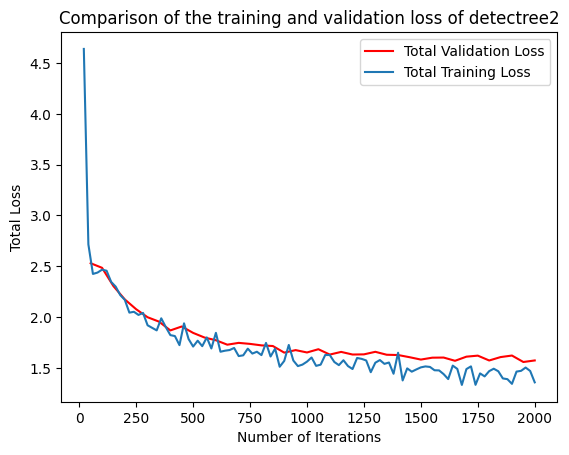

In [7]:
### Plot training and validation loss on the same plot to check how the training has gone

import json
import matplotlib.pyplot as plt
from detectree2.models.train import load_json_arr

#out_dir = "/content/drive/Shareddrives/detectree2/models/230103_resize_full"
experiment_folder = out_dir

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x],
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], label='Total Validation Loss', color='red')
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], label='Total Training Loss')

plt.legend(loc='upper right')
plt.title('Comparison of the training and validation loss of detectree2')
plt.ylabel('Total Loss')
plt.xlabel('Number of Iterations')
plt.show()

### How did the AP50 change through time?

Early stopping means that if the AP50 stops increasing after the ```patience``` interval, training will terminate and the best model will be saved.

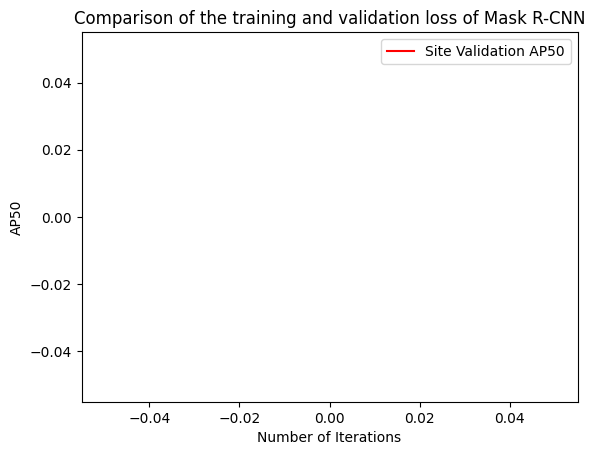

In [ ]:
### Plot ap50
# IF THERE ARE MULTIPLE NAMES/SITES

import json
import matplotlib.pyplot as plt
from detectree2.models.train import load_json_arr

experiment_folder = out_dir

names = ["Paracou2016", "Danum", "SepilokE", "SepilokW", "Paracou2019", "ParacouUAV", "BCI_50ha"]
name = names[6]
#name = "ParacouMS"
experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if name + '_val/segm/AP50' in x],
    [x[name + '_val/segm/AP50'] for x in experiment_metrics if name + '_val/segm/AP50' in x], label='Site Validation AP50', color='red')

plt.legend(loc='upper right')
plt.title('Validation AP50 loss of detectree2')
plt.ylabel('AP50')
plt.xlabel('Number of Iterations')
plt.show()

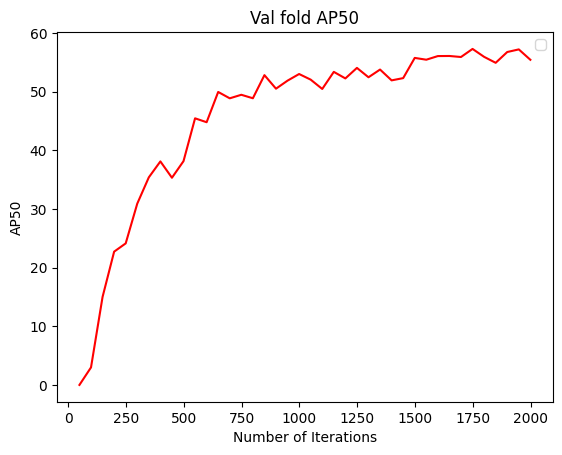

In [9]:
### Plot ap50

import json
import matplotlib.pyplot as plt
from detectree2.models.train import load_json_arr

experiment_folder = out_dir
#name = names[0]
name = "ParacouMS"
experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'segm/AP50' in x],
    [x['segm/AP50'] for x in experiment_metrics if 'segm/AP50' in x], color='red')

plt.legend(loc='upper right')
plt.title('Val fold AP50')
plt.ylabel('AP50')
plt.xlabel('Number of Iterations')
plt.show()

## Make predictions on the validation set and visualise

In [ ]:
cfg.INPUT.MIN_SIZE_TEST = 900
cfg.INPUT.MAX_SIZE_TEST = 1050

In [ ]:
import os

def get_latest_model_path(output_dir):
    """
    Find the model file with the highest index in the specified output directory.

    Args:
        output_dir (str): The directory where the model files are stored.

    Returns:
        str: The path to the model file with the highest index.
    """
    # List all files in the output directory and filter those that match the "model_X.pth" pattern
    model_files = [f for f in os.listdir(output_dir) if f.startswith("model_") and f.endswith(".pth")]

    if not model_files:
        raise FileNotFoundError(f"No model files found in the directory {output_dir}")

    # Sort the files by the numeric index extracted from the filename
    latest_model_file = max(model_files, key=lambda f: int(f.split('_')[1].split('.')[0]))

    # Return the full path to the latest model file
    return os.path.join(output_dir, latest_model_file)

In [ ]:
import os
from detectree2.models.train import combine_dicts
import cv2
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from PIL import Image
import numpy as np
import rasterio

# Configuration for the new routine
name1 = "Paracou"
appends = "15_15_0.7"  # Ensure this is defined
train_location = f"/content/drive/MyDrive/WORK/detectree2/data/{name1}/tilesMS_{appends}/train/"

# Register the dataset if not already done
#MetadataCatalog.get(name1 + "_train").set(thing_classes=['tree'])
trees_metadata = MetadataCatalog.get("ParacouMS" + "_val")

# Load the combined dictionaries for the validation fold
#val_fold1 = 1  # Make sure this is defined
dataset_dicts = combine_dicts(train_location, val_fold, mode='val')

# Retain the cfg from training

# Set up the configuration and the predictor
#cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for this model
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Assuming binary classification (tree or not)
#cfg.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675, 103.530, 116.280][:5]  # Adjust for the number of bands
#cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0, 1.0, 1.0][:5]  # Adjust for the number of bands
#cfg.INPUT.FORMAT = "BGR"  # Adjust if using a different format

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.35
cfg.MODEL.WEIGHTS = get_latest_model_path(out_dir)

print(cfg.MODEL.WEIGHTS)

predictor = DefaultPredictor(cfg)

# Function to normalize and convert multi-band image to RGB if needed
def prepare_image_for_visualization(image):
    if image.shape[2] == 3:
        # If the image has 3 bands, assume it's RGB
        image = np.stack([
            cv2.normalize(image[:, :, i], None, 0, 255, cv2.NORM_MINMAX)
            for i in range(3)
        ], axis=-1).astype(np.uint8)
    else:
        # If the image has more than 3 bands, choose the first 3 for visualization
        image = image[:, :, :3]  # Or select specific bands
        image = np.stack([
            cv2.normalize(image[:, :, i], None, 0, 255, cv2.NORM_MINMAX)
            for i in range(3)
        ], axis=-1).astype(np.uint8)

    return image

# Loop through the dataset and visualize predictions
for d in dataset_dicts:
    #img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)  # Use IMREAD_UNCHANGED to correctly handle multi-band images
    with rasterio.open(d["file_name"]) as src:
        img = src.read()  # Read all bands
        img = np.transpose(img, (1, 2, 0)).astype("float32")  # Convert to HWC format
        #img = prepare_image_for_visualization(img)  # Normalize and prepare for visualization
        print(img.shape)
    # Handle multi-band images correctly (if your model expects 5 channels)
    #if img.shape[-1] != 3:
    #    img = img[:, :, :3]  # Example: Select the first 3 bands if needed

    outputs = predictor(img)
    #v = Visualizer(img[:, :, ::-1], metadata=trees_metadata, scale=0.7)  # remove the colors of unsegmented pixels
    #img = prepare_image_for_visualization(img)
    img = img[:, :, :3]/10
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)  # remove the colors of unsegmented pixels
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    display(Image.fromarray(image))


Output hidden; open in https://colab.research.google.com to view.